# Hotele na wakacje

## Wstępna ocena przydatności danych

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.ensemble import RandomForestClassifier

sns.set()

In [2]:
df = pd.read_csv('hotels2.csv', index_col='id')

In [3]:
df.describe(include='all')

,name,region,country,latitude,longitude,ranking,ranking_out_of,rating,num_reviews,photo_count,amenities,brand,awards,price_level
count,1165,1165,1165,1165.000000,1165.000000,1165.00000,1165.000000,1165.000000,1165.000000,1165.000000,1125,487,598,1165
unique,1163,6,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,168,10,4
top,Emirates Grand Hotel,Emirate of Dubai,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pool,Free parking,Restaurant,Beachfront,Beach ...",Catalonia,"Travelers Choice 2023,Travelers Choice 2022",$$
freq,2,510,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,15,283,544
mean,NaN,NaN,NaN,31.607489,35.995338,147.04206,597.191416,4.337339,1929.244635,1560.814592,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,6.851927,19.677281,155.82979,372.791391,0.508456,2405.844558,2328.728259,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,24.816820,2.070631,1.00000,1.000000,2.500000,1.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,25.220015,27.138655,24.00000,218.000000,4.000000,219.000000,168.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,27.907465,34.327927,81.00000,553.000000,4.500000,1073.000000,596.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,38.424140,55.266380,242.00000,982.000000,4.500000,2607.000000,1857.000000,NaN,NaN,NaN,NaN


In [4]:
df.select_dtypes(include=['number']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 1006161 to 9865057
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        1165 non-null   float64
 1   longitude       1165 non-null   float64
 2   ranking         1165 non-null   int64  
 3   ranking_out_of  1165 non-null   int64  
 4   rating          1165 non-null   float64
 5   num_reviews     1165 non-null   int64  
 6   photo_count     1165 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 72.8 KB


In [5]:
df.select_dtypes(exclude=['number']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 1006161 to 9865057
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1165 non-null   object
 1   region       1165 non-null   object
 2   country      1165 non-null   object
 3   amenities    1125 non-null   object
 4   brand        487 non-null    object
 5   awards       598 non-null    object
 6   price_level  1165 non-null   object
dtypes: object(7)
memory usage: 72.8+ KB


## Przygotowanie danych

In [6]:
df['price_level'].unique()

array(['$$$', '$$$$', '$$', '$'], dtype=object)

In [7]:
df['price_level_num'] = df.price_level.apply(len)
df['rating'] = df.rating.apply(lambda x: 1 if x >= 4.5 else 0)

<Axes: xlabel='price_level_num', ylabel='Count'>

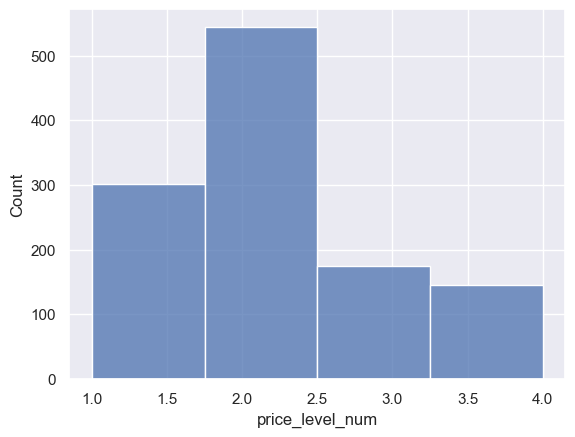

In [8]:
sns.histplot(df, x='price_level_num', bins=4)

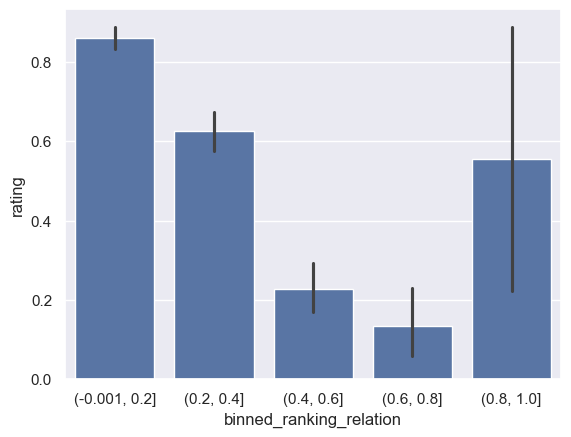

In [9]:
df['ranking_relation'] = round(df.ranking / df.ranking_out_of, 2)
df['binned_ranking_relation'] = pd.cut(df['ranking_relation'], bins=5)
sns.barplot(df, x='binned_ranking_relation',y='rating');

In [10]:
df.drop('binned_ranking_relation', axis='columns', inplace=True)

In [11]:
df_amenities = df.amenities.str.get_dummies(',').add_prefix('amenities_')
amenities_count = df_amenities.sum().sort_values(ascending=False)
amenities_count[amenities_count > 10]

amenities_Air conditioning     1062
amenities_Non-smoking rooms    1023
amenities_Laundry Service       988
amenities_Safe                  986
amenities_Internet              977
                               ... 
amenities_Canoeing               13
amenities_Bicycle Tours          12
amenities_Golf course            12
amenities_Georgian               11
amenities_Canoeing Off-site      11
Length: 288, dtype: int64

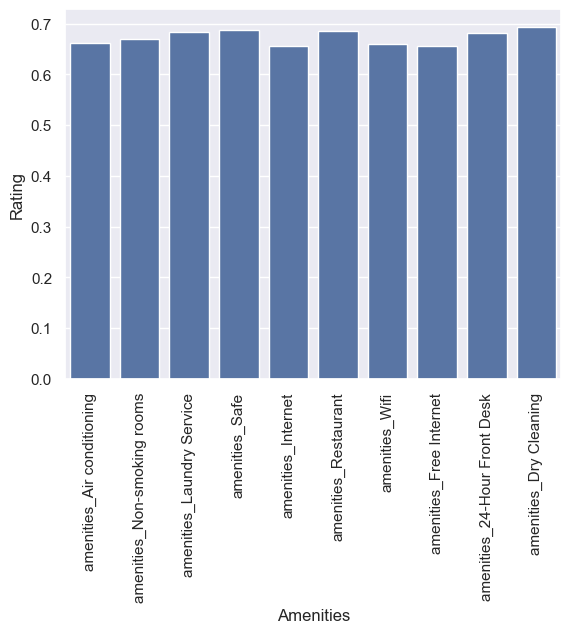

In [12]:
mean_ratings = pd.Series(dtype='float64')
for col in amenities_count[:10].index:
    df_amenities_non_zero = df_amenities[col][df_amenities[col] != 0]
    mean_rating = df_amenities_non_zero.multiply(df.loc[df_amenities_non_zero.index, 'rating'], axis="index").mean()
    mean_ratings.loc[col] = mean_rating

mean_ratings_df = mean_ratings.reset_index()
mean_ratings_df.columns = ['Amenities', 'Rating']
sns.barplot(x='Amenities', y='Rating', data=mean_ratings_df)
plt.xticks(rotation=90)
plt.show()

In [13]:
df.amenities.fillna('', inplace=True)

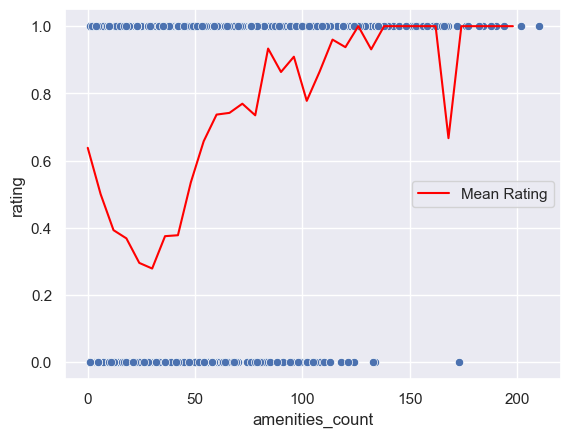

In [14]:
df['amenities_count'] = df.amenities.apply(lambda x: len(x.split(',')))
bins = range(0, df['amenities_count'].max(), 6) 
df['amenities_count_binned'] = pd.cut(df['amenities_count'], bins, right=False)
mean_ratings = df.groupby('amenities_count_binned')['rating'].mean()
sns.lineplot(x=bins[:-1], y=mean_ratings.values, color='red', label='Mean Rating')
sns.scatterplot(data=df, x="amenities_count", y="rating")
plt.legend()
df.drop('amenities_count_binned', axis='columns', inplace=True)
plt.show()

In [15]:
df_awards = df.awards.str.get_dummies(',').add_prefix('awards_')
awards_count = df_awards.sum().sort_values(ascending=False)
awards_count

awards_Travelers Choice 2023                     501
awards_Travelers Choice 2022                     416
awards_Travelers Choice Best of the Best 2023     33
awards_Travelers Choice Best of the Best 2022     31
dtype: int64

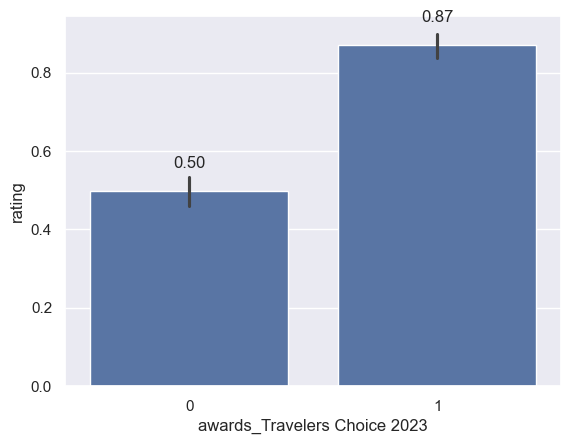

In [16]:

ax = sns.barplot(df_awards.join(df.rating), x="awards_Travelers Choice 2023", y='rating');
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 20), 
                textcoords = 'offset points')

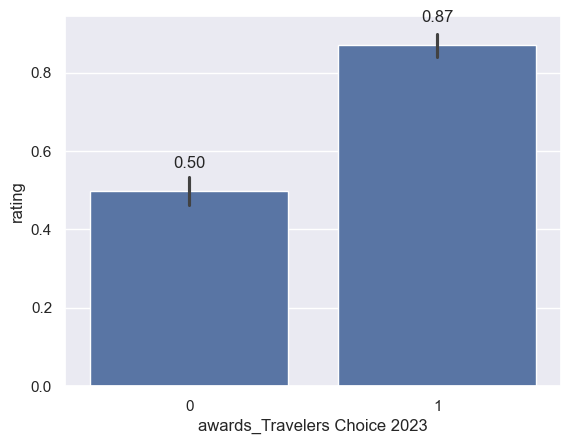

In [17]:
ax = sns.barplot(df_awards.join(df.rating), x="awards_Travelers Choice 2023", y='rating');
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 20), 
                textcoords = 'offset points')

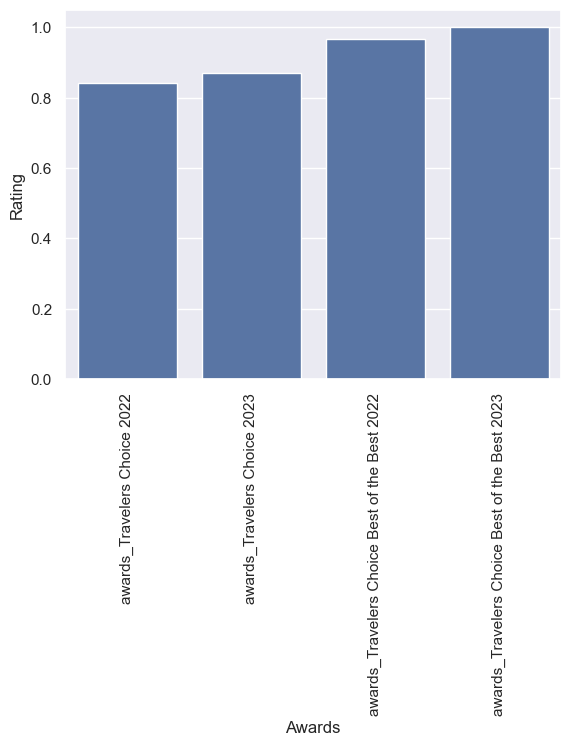

In [18]:
df_awards = df.awards.str.get_dummies(',').add_prefix('awards_')
mean_ratings = pd.Series(dtype='float64')
for col in df_awards.columns:
    df_amenities_non_zero = df_awards[col][df_awards[col] != 0]
    mean_rating = df_amenities_non_zero.multiply(df.loc[df_amenities_non_zero.index, 'rating'], axis="index").mean()
    mean_ratings.loc[col] = mean_rating

mean_ratings_df = mean_ratings.reset_index()
mean_ratings_df.columns = ['Awards', 'Rating']
sns.barplot(x='Awards', y='Rating', data=mean_ratings_df)
plt.xticks(rotation=90)
plt.show()

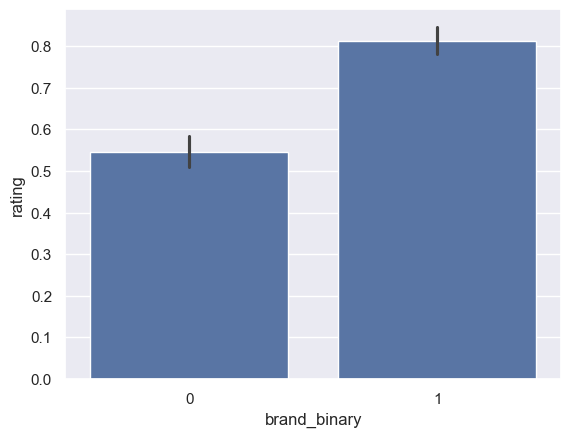

In [19]:
df['brand_binary'] = df.brand.apply(lambda x: 0 if pd.isnull(x) else 1)
sns.barplot(df, x="brand_binary", y='rating');

In [20]:
df_to_save = df.drop(['price_level', 'name', 'amenities', 'awards', 'country', 'ranking', 'ranking_out_of', 'brand'], axis= 'columns')
df_to_save = pd.get_dummies(df_to_save)

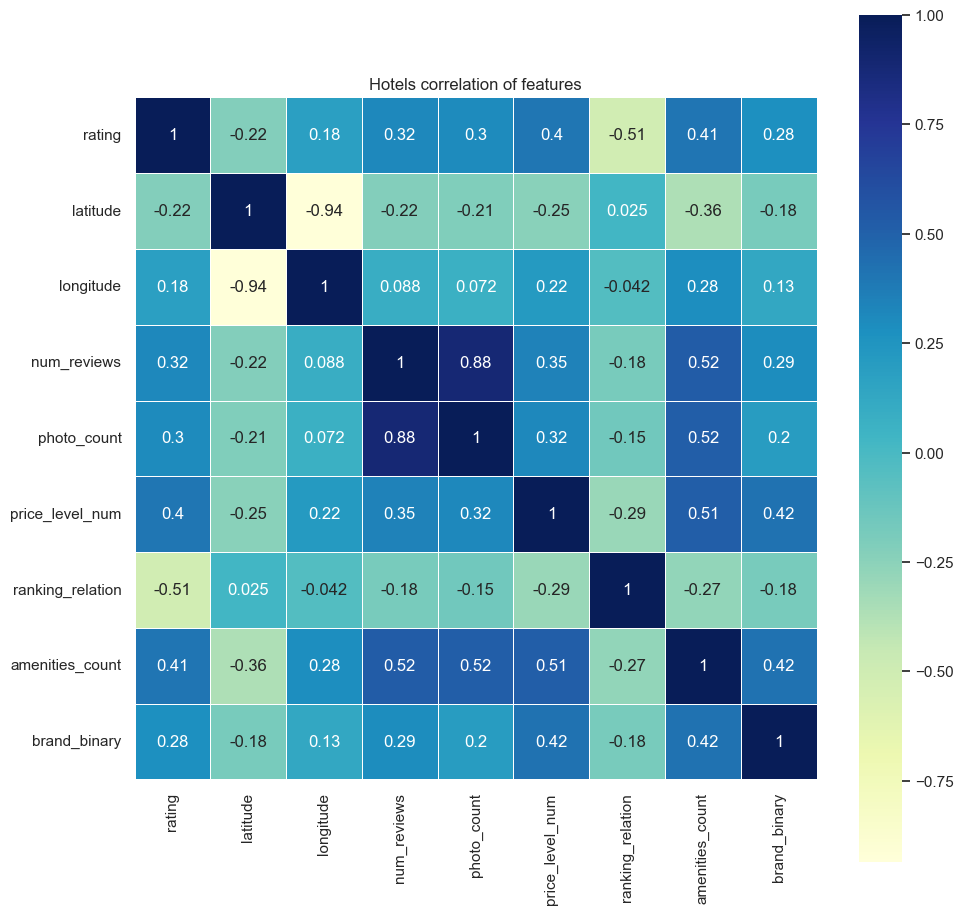

In [26]:
plt.subplots(figsize=(11, 11))
plt.title('Hotels correlation of features')
ax = sns.heatmap(df_to_save[["rating", "latitude", "longitude", "num_reviews", "photo_count", "price_level_num", "ranking_relation", "amenities_count", "brand_binary"]].corr(), 
                 annot=True, 
                 linewidths=.5, 
                 cmap="YlGnBu",
                 square=True
                );

In [44]:
df_to_save.to_csv('hotels_with_dummy_regions.csv')

In [45]:
X = df_to_save.drop('price_level_num', axis='columns')
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_to_save.price_level_num, test_size=0.2, random_state=1)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_train_split.shape, X_validation.shape, X_test.shape

((932, 14), (745, 14), (187, 14), (233, 14))

## Modelowanie (klasyfikacja ceny)

Algorytm naiwny zawsze wybierając 2 będzie miał 47% dokładności

In [46]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 20)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_, knn_gscv.best_score_

({'n_neighbors': 7}, 0.613669640814459)

In [47]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_split, y_train_split)
y_pred = knn.predict(X_validation)
confusion_matrix(y_validation, y_pred)

array([[37, 14,  2,  0],
       [18, 68,  5,  0],
       [ 2, 10,  2,  2],
       [ 4, 13,  7,  3]], dtype=int64)

In [48]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.70      0.65        53
           2       0.65      0.75      0.69        91
           3       0.12      0.12      0.12        16
           4       0.60      0.11      0.19        27

    accuracy                           0.59       187
   macro avg       0.49      0.42      0.41       187
weighted avg       0.58      0.59      0.56       187



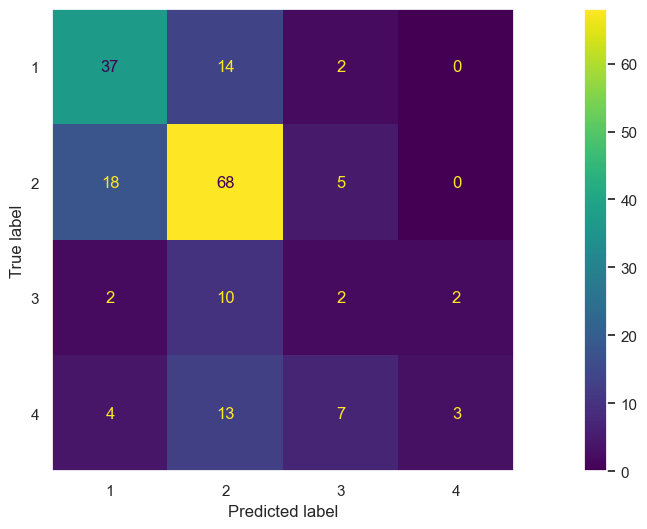

In [49]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [50]:
clf = CategoricalNB(min_categories=X.nunique())
cross_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.58510638 0.5212766  0.5483871  0.52688172 0.51612903 0.51612903
 0.52688172 0.50537634 0.5483871  0.52688172]


0.5321436742164265

              precision    recall  f1-score   support

           1       0.80      0.30      0.44        53
           2       0.52      0.96      0.67        91
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        27

    accuracy                           0.55       187
   macro avg       0.33      0.31      0.28       187
weighted avg       0.48      0.55      0.45       187



c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

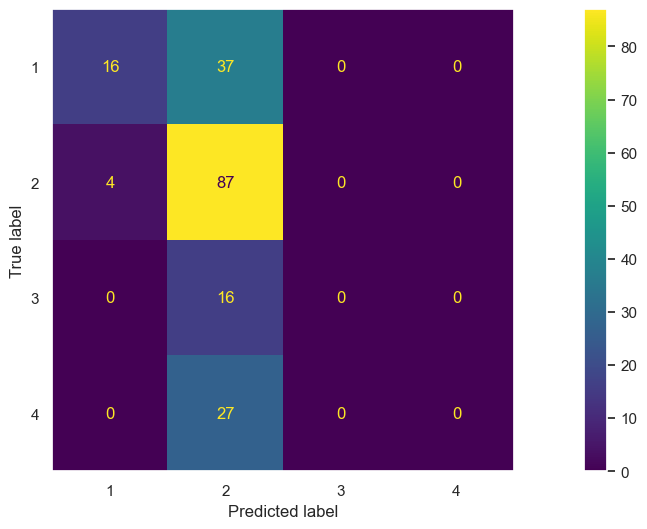

In [51]:
clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_validation)
print(classification_report(y_validation, y_pred))
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [52]:
lda = LDA(store_covariance=True)
cross_scores = cross_val_score(lda, X_train, y_train, cv=10)
print(cross_scores)
cross_scores.mean()

[0.70212766 0.55319149 0.62365591 0.62365591 0.58064516 0.60215054
 0.65591398 0.61290323 0.58064516 0.56989247]


0.6104781514527569

In [53]:
lda.fit(X_train_split, y_train_split)
lda_pred = lda.predict(X_validation)
print(classification_report(y_validation, lda_pred))

              precision    recall  f1-score   support

           1       0.66      0.58      0.62        53
           2       0.62      0.75      0.68        91
           3       0.29      0.31      0.30        16
           4       0.71      0.37      0.49        27

    accuracy                           0.61       187
   macro avg       0.57      0.50      0.52       187
weighted avg       0.62      0.61      0.60       187



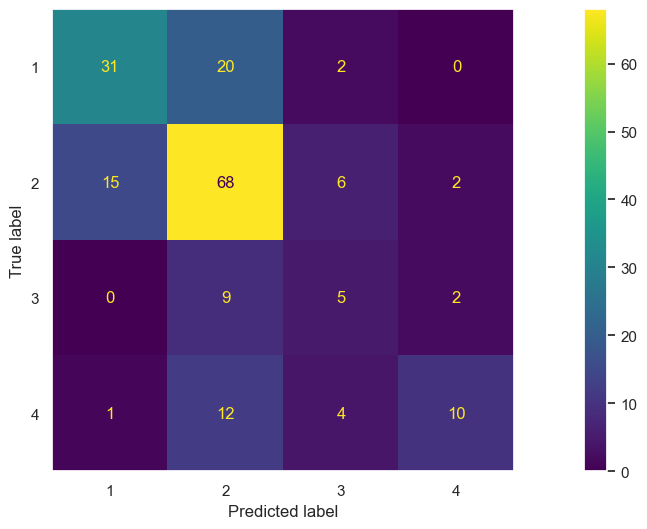

In [54]:
c_matrix = confusion_matrix(y_validation, lda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [55]:
rfc=RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [300, 600, 800],
    'max_depth' : [10,12,14,16],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 12, 14, 16],
                         'n_estimators': [300, 600, 800]})

In [56]:
CV_rfc.best_params_

{'max_depth': 14, 'n_estimators': 800}

In [57]:
CV_rfc.best_score_

0.6705939853947444

In [58]:
rfc_pred = CV_rfc.best_estimator_.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           1       0.71      0.68      0.70        57
           2       0.69      0.82      0.75       112
           3       0.30      0.19      0.23        32
           4       0.71      0.53      0.61        32

    accuracy                           0.66       233
   macro avg       0.60      0.56      0.57       233
weighted avg       0.64      0.66      0.64       233



Najlepszym klasyfikatorem został Random Forest Classifier